# We implement an Extended Kalman Filter (EKF) on a double integrator $\ddot{x} = \epsilon$ with range/bearing measurements
We follow https://www.intechopen.com/books/introduction-and-implementations-of-the-kalman-filter/introduction-to-kalman-filter-and-its-applications section 3

### Process Model
\begin{align}
x_{k+1} &= \pmatrix{I_{3 \times 3} & I_{3 \times 3} \Delta t \\ 0_{3 \times 3} & I_{3 \times 3}} x_{k} + v_k \\
   &= Ax_k + v_k
\end{align}
   

where

$ x_k = [p_k^T, v_k^T] $ 

$v_k \sim N(0, Q)$

$ Q = \pmatrix{ 0_{3 \times 3} & & 0_{3 \times 3} \\
                                & \sigma_x^2 & 0 & 0 \\
                 0_{3 \times 3} & 0 & \sigma_y^2 & 0 \\
                                & 0 & 0 & \sigma_z^2} $

#### Prediction step
$ \hat{x}_{k+1}^- = A\hat{x}_k^+$

$ P_{k+1}^- = AP_k^+ A^T + Q_m$

where

$Q_m = \pmatrix{ 0_{3 \times 3} & 0_{3 \times 3} \\
                 0_{3 \times 3} & I_{3 \times 3} \sigma_v^2 } $ is the model's Q matrix (note that its different from the real Q here)

### Measurement model

 <div style="width: 100%;">
     <div style="width: 40%; float: left;">
      <img src="spherical_coordinates.png" alt="spherical coordinates" width="200"/>
    </div>
     <div style="width: 49%; float: left;">
\begin{align}
    z_k = \pmatrix{\phi \\ \theta \\ r} = 
    \pmatrix{\text{atan}\left(\frac{x_t-x_s}{y_t - y_s}\right) \\
         \text{atan}\left(\frac{z_t - z_s}{r_{xy}}\right) \\
         r_{xyz}} + w_k
\end{align}
    </div>
</div>
<br style="clear: left;">

where

$ r_{xy} = \sqrt{(x_t-x_s)^2 + (y_t-y_s)^2} $, 
$ r_{xyz} = \sqrt{(x_t-x_s)^2 + (y_t-y_s)^2 + (z_t-y_s)^2} $

$w_k \sim N(0, R)$

$R = \pmatrix{0.02^2 & 0 & 0 \\
              0 & 0.02^2 & 0 \\
              0 & 0 & 1.0^2 } $

#### Update step
$$ 
H_k = \frac{\partial z_k}{\partial x_k}\Big|_{\hat{x}_k^-} =
   \pmatrix{ \frac{-y}{x^2+y^2} & \frac{x}{x^2+y^2} & 0 \\
             \frac{-xz}{r_{xyz}^2 r_{xy}} & \frac{-yz}{r_{xyz}^2 r_{xy}} & \frac{1}{r_{xy}} & 0_{3 \times 3}\\
             \frac{x}{r_{xyz}} & \frac{y}{r_{xyz}} & \frac{z}{r_{xyz}}}
$$

$ \tilde{y}_k = z_k - h(\hat{x}_k^-)$

$ K_k = P_k^- H_k^T (R_m + H_k P_k^- H_k^T)^{-1} $

$ \hat{x}_k^+ = \hat{x}_k^- + K_k \tilde{y} $

$ P_k^+ = (I - K_k H_k)P_k^- $

where

$R_m = \pmatrix{0.02^2 & 0 & 0 \\
              0 & 0.02^2 & 0 \\
              0 & 0 & 1.0^2 } $ is the model's measurement noise covariance (note here we use the same as the actual measurement's covariance $Q$)

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

In [29]:
# PARAMS
v_std = 0.5
# For now, we set them all equal
x_std = v_std
y_std = v_std
z_std = v_std

x0 = np.array([2,-2,0,5,5.1,0.1])
P0 = np.block([[np.eye(3) * 4**2, np.zeros((3,3))],
               [np.zeros((3,3)), np.eye(3) * 0.4**2]])
a = np.zeros(3)
dt = 1
N = 20

In [ ]:
class EKF():
    
    def __init__(self, x0, P0, p_std, v_std, a_std, dt):
        self.x = x0
        self.P = P0
        self.dt = dt
        self.Q = np.block([[1/4 * dt**4 * np.eye(3), 1/2 * dt**3 * np.eye(3)],
                           [1/2 * dt**3 * np.eye(3), dt**2 * np.eye(3)]])
        self.R = a_std**2 *np.block([[np.eye(3) * p_std**2, np.zeros((3,3))],
                                     [np.zeros((3,3)), np.eye(3) * v_std**2]])
        self.A = np.block([[np.eye(3), np.eye(3)*dt],
                           [np.zeros((3,3)), np.eye(3)]])
        self.B = np.block([[1/2 * np.eye(3) * dt**2],
                           [np.eye(3) * dt]])
        
    def predict(self, a):
        self.x = self.A @ self.x + self.B @ a
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.x
        
    def update(self, z):
        y = z - self.x
        K = self.P @ np.linalg.pinv(self.R + self.P)
        self.x = self.x + K@y
        self.P = (np.eye(6) - K) @ self.P
        return self.x

In [4]:
import autograd.numpy as np
from autograd import jacobian

In [26]:
class EKF():
    
    def __init__(self, f, g, Q, R):
        self.f = f
        self.F = jacobian(f)
        self.g = g
        self.G = jacobian(g)
        self.Q = Q
        self.R = R

    def predict(self, x, P, u):
        x = self.f(x, u)
        P = self.F(x,u) @ P @ self.F(x,u).T + self.Q
        return x, P
        
    def update(self, x, P, z):
        y = z - self.g(x)
        Gx = self.G(x)
        K = self.P @ Gx @ np.linalg.pinv(Gx @ self.P @ Gx.T + self.R)
        x = self.x + K@y
        P = (np.eye(P.shape[0]) - K @ G) @ P
        return x, P

In [27]:
from dynamics.doubleintegrator import DoubleIntegrator
di = DoubleIntegrator(2)
ddi = di.discretize(0.1)
def g(x):
    return np.linalg.norm(x)
ddi.g = g
ekf = EKF(ddi.f, ddi.g, np.eye(2), np.eye(1))

In [28]:
jacobian(ddi.g, 0)(np.array([2.0,2.0]))

array([0.707, 0.707])

In [6]:
x0 = np.array([0.,1.])
u = np.array([2.])
ddi.f(x0,u)

array([0.1, 1.2])

In [7]:
jacobian(ddi.f)(x0,u)

array([[1. , 0.1],
       [0. , 1. ]])

In [30]:
from scipy import signal

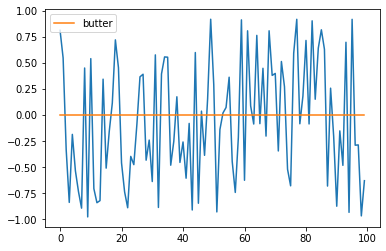

In [78]:
u_rough = np.random.uniform(-1,1,100).reshape(-1,1)
plt.plot(u_rough)

sos = signal.butter(10, 0.1, output='sos')
u_butter = signal.sosfilt(sos, u_rough)
plt.plot(u_butter, label=f"butter")

plt.legend()

In [86]:
t = np.arange(0, 10, 0.1)
size = np.shape(np.array([-1])) + (t.shape[-1],)
size

(1, 100)

In [87]:
np.shape(np.array([-1]))

(1,)